In [1]:
import sys
Path = '/remote/tychodata/ftairli/work/Projects/Geometry_Reconstruction/Code/'
if Path not in sys.path:
    sys.path.append(Path)
    
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from Dataset import GraphDatasetContainer
from TrainingModule import IterateInBatches

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
Name = 'Model_2_2'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)


        Add self loops and only check propagation downstream (removed)
        Also add max pooling and concatenate
        And Swwitch to GATConv
        Add Construction of edge features to be fed into the GATConv
            For X_Features     [Chi_i,Charge,Time,Duration] [0,1,2,3]
            For Edge_Features  [DeltaChi,DeltaT] [0,2]
        Added Station Data
        Trained with Standard Nodes connections
        Making the Model Deeper, Now will have 5 layers of GATConv
        


In [3]:
MinValLossEpoch = np.argmin(Tracker.EpochValLoss)
Model.load_state_dict(Tracker.ModelStates[MinValLossEpoch])

<All keys matched successfully>

In [4]:
print(f'Final Loss           : {Tracker.EpochLoss[-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss[-1]}')

Final Loss           : 0.10567837555347767
Final Validation Loss: 0.10099685790323241


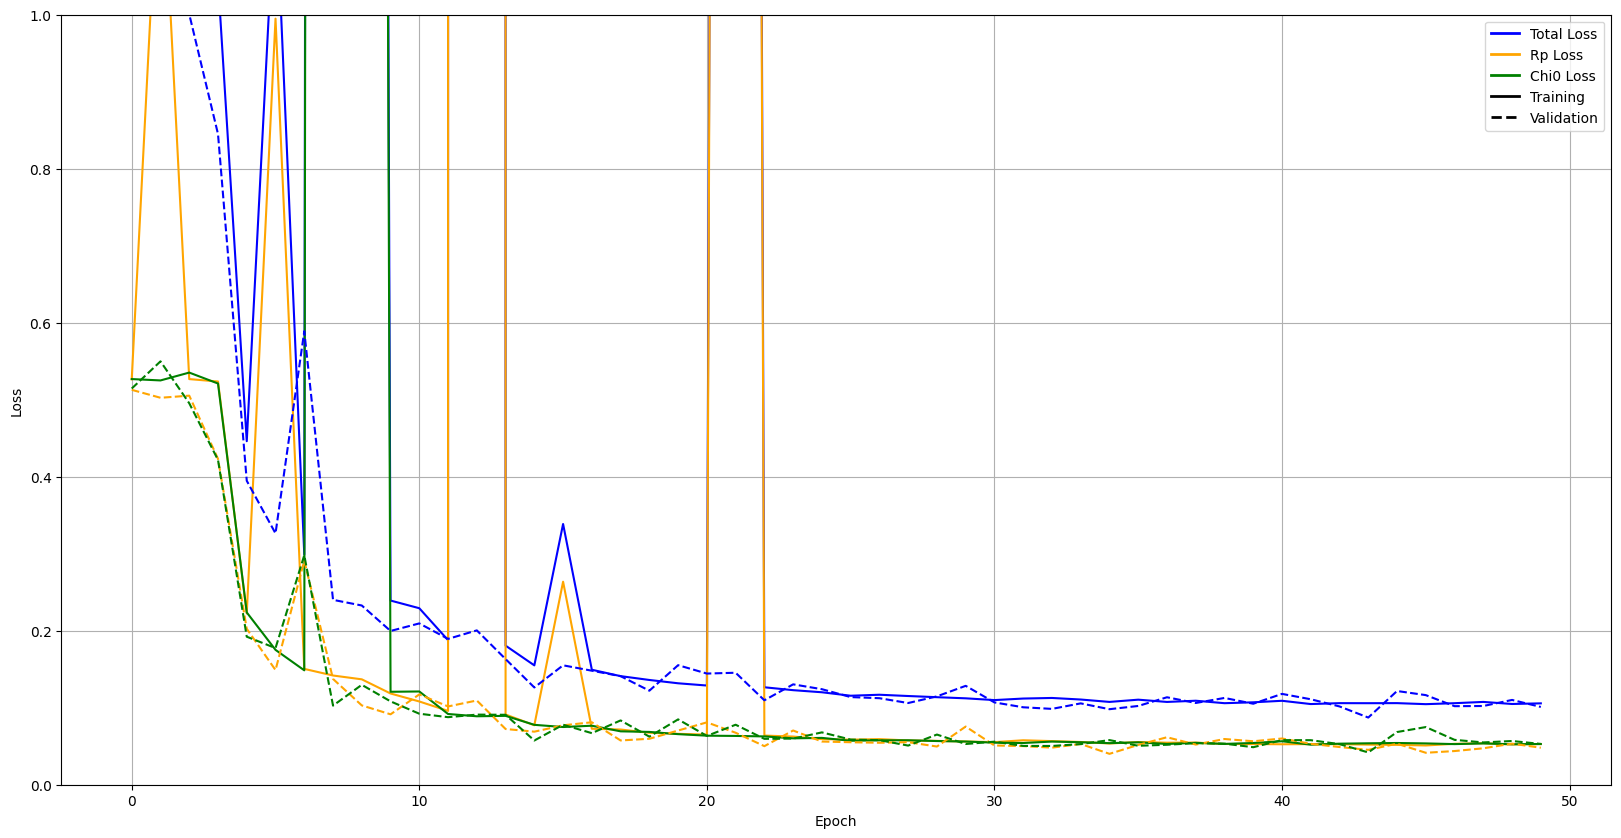

In [5]:
# Loss Plot
Total_loss = Tracker.EpochLoss
Rp_loss = Tracker.EpochLossRp
Chi0_loss   = Tracker.EpochLossChi0

Total_loss_val = Tracker.EpochValLoss
Rp_loss_val = Tracker.EpochValLossRp
Chi0_loss_val   = Tracker.EpochValLossChi0

Nepochs = len(Total_loss)
plt.figure(figsize=(20, 10))

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']

# Plot training loss
plt.plot(Total_loss , color=colors[0], label='Total Loss - Training')
plt.plot(Rp_loss    , color=colors[1], label='Rp Loss    - Training')
plt.plot(Chi0_loss  , color=colors[2], label='Chi0 Loss  - Training')

# # Plot validation loss
plt.plot(Total_loss_val , color=colors[0], linestyle='dashed', label='Total Loss  - Validation')
plt.plot(Rp_loss_val    , color=colors[1], linestyle='dashed', label='Rp Loss     - Validation')
plt.plot(Chi0_loss_val  , color=colors[2], linestyle='dashed', label='Chi0   Loss - Validation')

# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black'  , lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Rp Loss', 'Chi0 Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
# plt.yscale('log')
plt.grid()
# plt.savefig(f'{Name}_Loss.png', dpi=300)


In [6]:
# Load Dataset
datapath = '/remote/tychodata/ftairli/work/Projects/Geometry_Reconstruction/Data/RawData/'
GraphDataset = GraphDatasetContainer(0)
GraphDataset.Load(datapath, 'Run010')

from Training import GetTruths,GetRecTruths, GetFeatures, GetStationFeatures

ProcessingDataset = GraphDataset.GetProcessingDataset(GetTruths,GetFeatures,GetStationFeatures,True,True,True)
ProcessingDataset.AssignIndices()
ProcessingDataset.RandomIter = False

Feature Values are : [Chi,Charge,Centroid,Duration]
Truth Values are : [Chi0,Rp]
Station Feature Values are : [Chi,Charge,Centroid,Duration]


In [7]:
def UnnormaliseOutputs(Outputs):
    Chi0 = torch.acos(Outputs[:,0])
    Mean_Rp = 12800
    STD_Rp  = 5800
    Rp      = Outputs[:,1]*STD_Rp + Mean_Rp
    return torch.stack([Chi0, Rp], dim=1)

In [8]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RecTruths = GetRecTruths(GraphDataset)

ProcessingDataset.State = 'Test'
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchGraphBatching, BatchFeatures,BatchEdges,BatchEdgesWeights,BatchTruth in IterateInBatches(ProcessingDataset,256):
        Rec.append(RecTruths[EventIndex])
        BatchFeatures      = BatchFeatures     .to(device)
        BatchGraphBatching = BatchGraphBatching.to(device)
        BatchEdges         = BatchEdges        .to(device).to(torch.int32)
        BatchEdgesWeights  = BatchEdgesWeights .to(device)
        BatchTruth         = BatchTruth        .to(device)
        # print(f'EvI : {EvI} Edges.Shape : {BatchEdges.shape}')

        Truth.append(BatchTruth)
        Pred.append(Model(BatchFeatures,BatchEdges,BatchEdgesWeights,BatchGraphBatching))
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

Truth = UnnormaliseOutputs(Truth)
Pred  = UnnormaliseOutputs(Pred)
Rec   = UnnormaliseOutputs(Rec)

Truth = Truth.cpu()
Pred  = Pred .cpu()
Rec   = Rec  .cpu()


# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()




Dropping 0 NaN values


In [32]:
# Compute the Test Set with  Event Length
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RecTruths = GetRecTruths(GraphDataset)

ProcessingDataset.State = 'Test'
Truth = []
Pred  = []
Rec   = []
EventLength = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchGraphBatching, BatchFeatures,BatchEdges,BatchEdgesWeights,BatchTruth in IterateInBatches(ProcessingDataset,1):
        
        BatchFeatures      = BatchFeatures     .to(device)
        BatchGraphBatching = BatchGraphBatching.to(device)
        BatchEdges         = BatchEdges        .to(device)
        BatchEdgesWeights  = BatchEdgesWeights .to(device)
        BatchTruth         = BatchTruth        .to(device)
        
        # print(f'EvI : {EvI} Edges.Shape : {BatchEdges.shape}')

        Truth.append(BatchTruth)
        Pred.append(Model(BatchFeatures,BatchEdges,BatchEdgesWeights,BatchGraphBatching))
        Rec.append(RecTruths[EventIndex])
        EventLength.append(BatchGraphBatching.shape[0])

        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

Truth = UnnormaliseOutputs(Truth)
Pred  = UnnormaliseOutputs(Pred)
Rec   = UnnormaliseOutputs(Rec)

Truth = Truth.cpu()
Pred  = Pred .cpu()
Rec   = Rec  .cpu()


# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()

EventLength = np.array(EventLength)



Dropping 0 NaN values


In [9]:
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68)

In [17]:
# Chi0_Pred_MSE = MeanSquaredError(Truth[:,0],Pred[:,0])
# Rp_Pred_MSE   = MeanSquaredError(Truth[:,1],Pred[:,1])

# Chi0_Rec_MSE = MeanSquaredError(Truth[:,0],Rec[:,0])
# Rp_Rec_MSE   = MeanSquaredError(Truth[:,1],Rec[:,1])

# print(f'Mean Squared Error Chi0_Pred   : {Chi0_Pred_MSE}')
# print(f'Mean Squared Error Chi0_Rec    : {Chi0_Rec_MSE}')
# print()
# print(f'Mean Squared Error Rp_Pred     : {Rp_Pred_MSE}')
# print(f'Mean Squared Error Rp_Rec      : {Rp_Rec_MSE}')
# print()
# print(f'Ratio Mean Squared Error Chi0 : {Chi0_Pred_MSE/Chi0_Rec_MSE}')
# print(f'Ratio Mean Squared Error Rp   : {Rp_Pred_MSE/Rp_Rec_MSE}')
# print('_____________________________________________________')
# print()

# 68th percentile
Chi0_Pred_P68 = Percentile68(Truth[:,0],Pred[:,0])
Rp_Pred_P68   = Percentile68(Truth[:,1],Pred[:,1])

Chi0_Rec_P68 = Percentile68(Truth[:,0],Rec[:,0])
Rp_Rec_P68   = Percentile68(Truth[:,1],Rec[:,1])

print(f'68% Chi0_Pred   : {Chi0_Pred_P68/np.pi*180:.5} deg ')
print(f'68% Chi0_Rec    : {Chi0_Rec_P68 /np.pi*180:.5} deg')
print()
print(f'68% Rp_Pred     : {Rp_Pred_P68:.5} m')
print(f'68% Rp_Rec      : {Rp_Rec_P68 :.5} m')
print()
print(f'68% Ratio Chi0  : {Chi0_Pred_P68/Chi0_Rec_P68:.5}')
print(f'68% Ratio Rp    : {Rp_Pred_P68/Rp_Rec_P68:.5}')
print()


68% Chi0_Pred   : 6.3759 deg 
68% Chi0_Rec    : 0.40196 deg

68% Rp_Pred     : 1229.8 m
68% Rp_Rec      : 37.786 m

68% Ratio Chi0  : 15.862
68% Ratio Rp    : 32.546



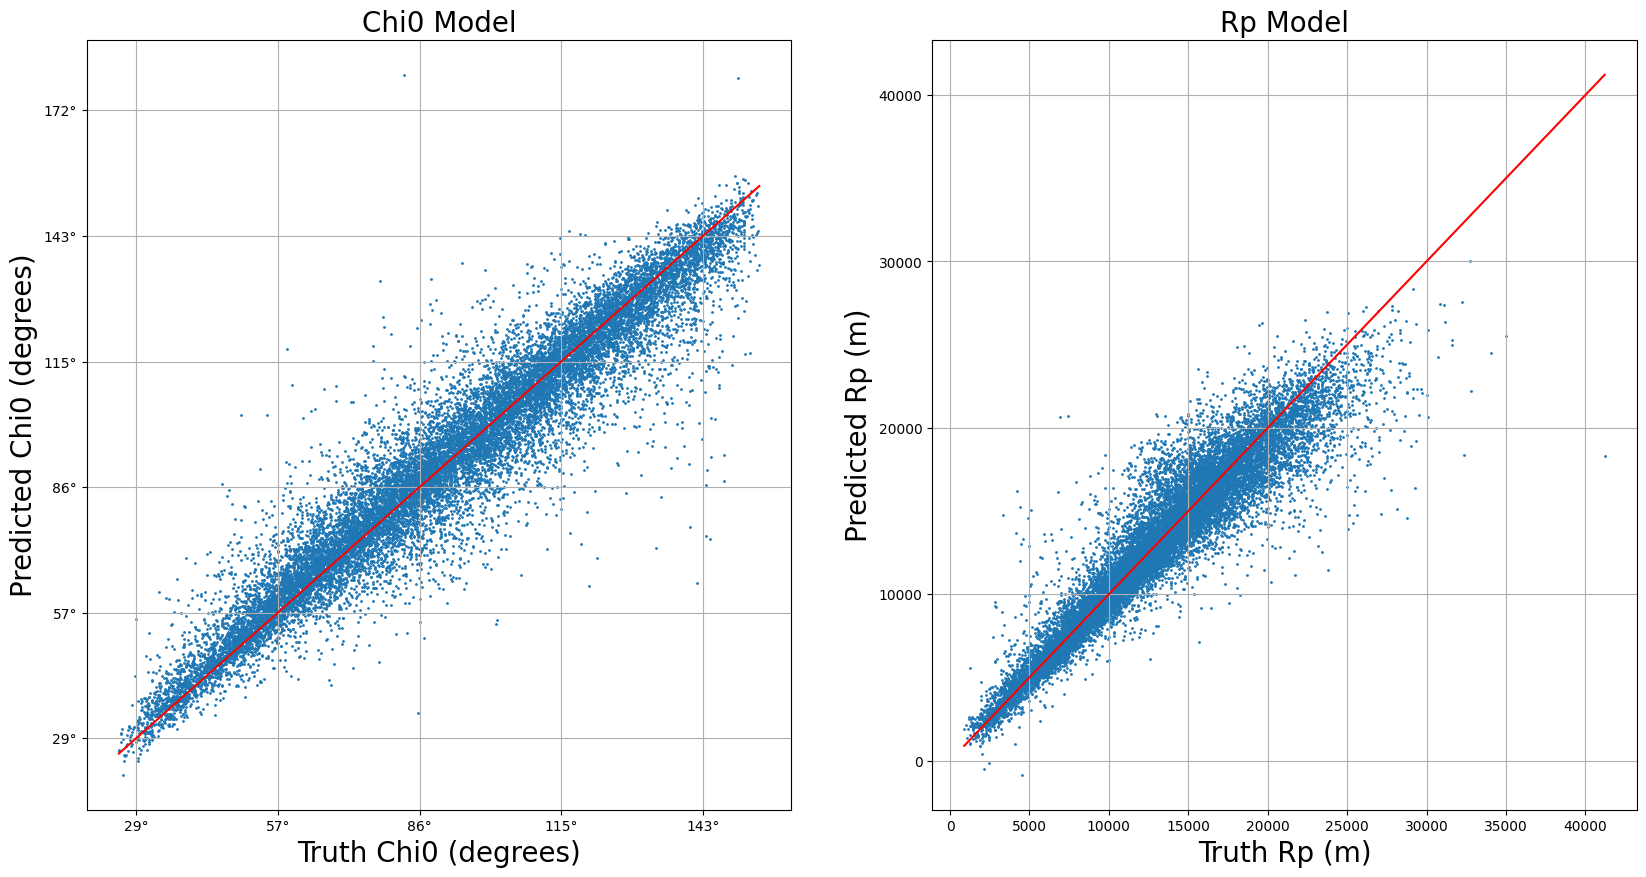

In [28]:
# Easy Scatter Plots of Truth vs Predicted
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(Truth[:, 0], Pred[:, 0], s=1)
ax[0].plot([min(Truth[:, 0]), max(Truth[:, 0])], [min(Truth[:, 0]), max(Truth[:, 0])], 'r')
ax[0].set_xlabel('Truth Chi0 (degrees)',fontsize=20)
ax[0].set_ylabel('Predicted Chi0 (degrees)',fontsize=20)
ax[0].set_title('Chi0 Model',fontsize=20)

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[0].grid()

# Scatter plot for the second subplot
ax[1].scatter(Truth[:, 1], Pred[:, 1], s=1)
ax[1].plot([min(Truth[:, 1]), max(Truth[:, 1])], [min(Truth[:, 1]), max(Truth[:, 1])], 'r')
ax[1].set_xlabel('Truth Rp (m)',fontsize=20)
ax[1].set_ylabel('Predicted Rp (m)',fontsize=20)
ax[1].set_title('Rp Model',fontsize=20)

ax[1].grid()
# plt.savefig(f'../Results/')

plt.show()


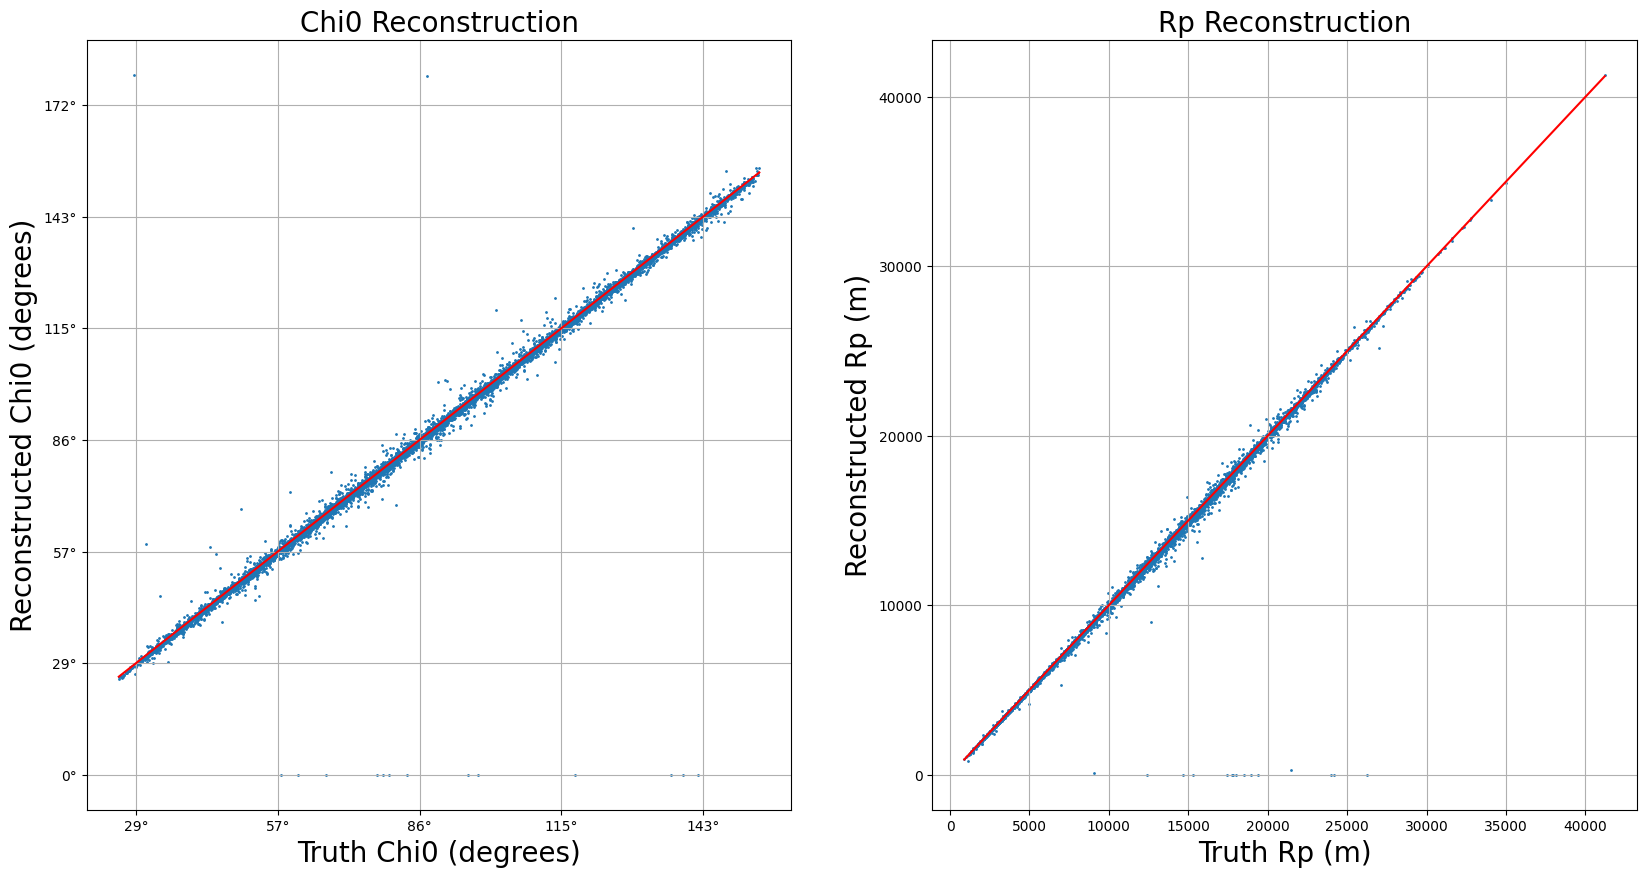

In [29]:
# Easy Scatter Plots of Truth vs Reconstruction
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(Truth[:, 0], Rec[:, 0], s=1)
ax[0].plot([min(Truth[:, 0]), max(Truth[:, 0])], [min(Truth[:, 0]), max(Truth[:, 0])], 'r')
ax[0].set_xlabel('Truth Chi0 (degrees)',fontsize=20)
ax[0].set_ylabel('Reconstructed Chi0 (degrees)',fontsize=20)
ax[0].set_title('Chi0 Reconstruction',fontsize=20)

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[0].grid()

# Scatter plot for the second subplot
ax[1].scatter(Truth[:, 1], Rec[:, 1], s=1)
ax[1].plot([min(Truth[:, 1]), max(Truth[:, 1])], [min(Truth[:, 1]), max(Truth[:, 1])], 'r')
ax[1].set_xlabel('Truth Rp (m)',fontsize=20)
ax[1].set_ylabel('Reconstructed Rp (m)',fontsize=20)
ax[1].set_title('Rp Reconstruction',fontsize=20)

ax[1].grid()
# plt.savefig(f'../Results/')

plt.show()


In [ ]:
# Deviation plots
import seaborn as sns

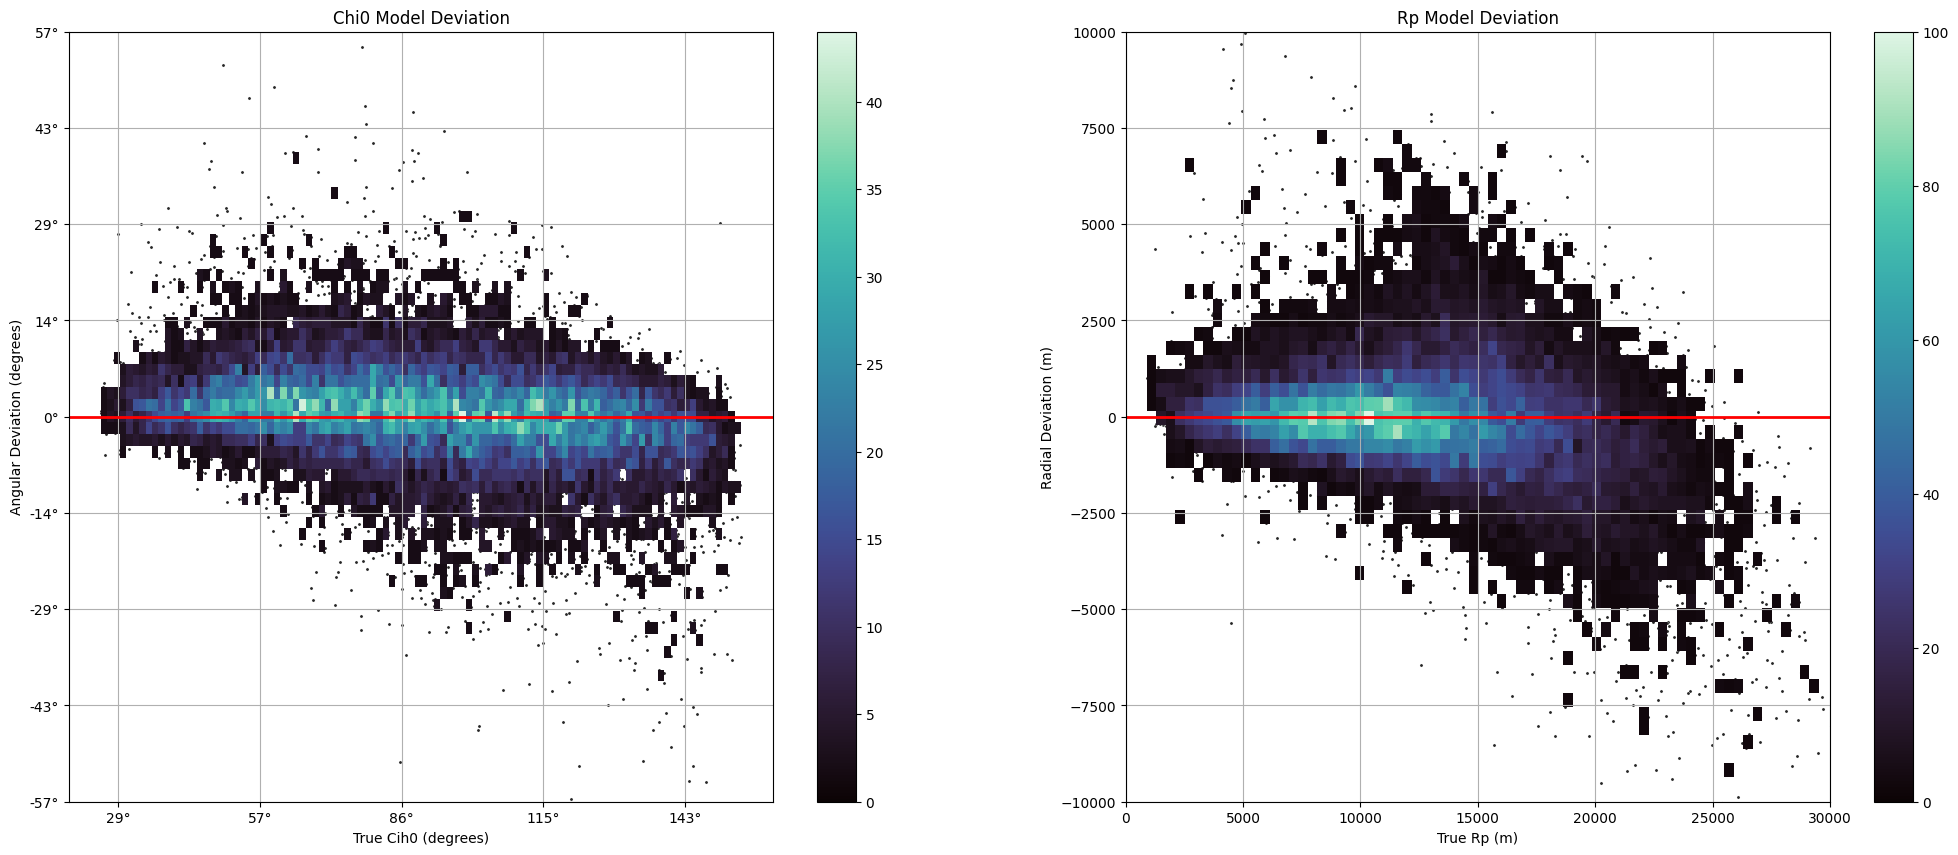

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = Truth[:, 0]
Y = Pred[:, 0] - Truth[:, 0]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.01,cmap = 'mako',cbar = True)
ax[0].set_xlabel('True Cih0 (degrees)') 
ax[0].set_ylabel('Angular Deviation (degrees)')
ax[0].set_title('Chi0 Model Deviation')
ax[0].axhline(0, color='red', lw=2)
ax[0].set_ylim(-1,1)
ax[0].grid()

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])




X = Truth[:, 1]
Y = Pred[:, 1] - Truth[:, 1]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.01,cmap = 'mako',cbar = True)
ax[1].set_xlabel('True Rp (m)')
ax[1].set_ylabel('Radial Deviation (m)')
ax[1].set_title('Rp Model Deviation')
ax[1].axhline(0, color='red', lw=2)
ax[1].set_ylim(-10000,10000)
ax[1].set_xlim(0,30000)
ax[1].grid()

plt.show()

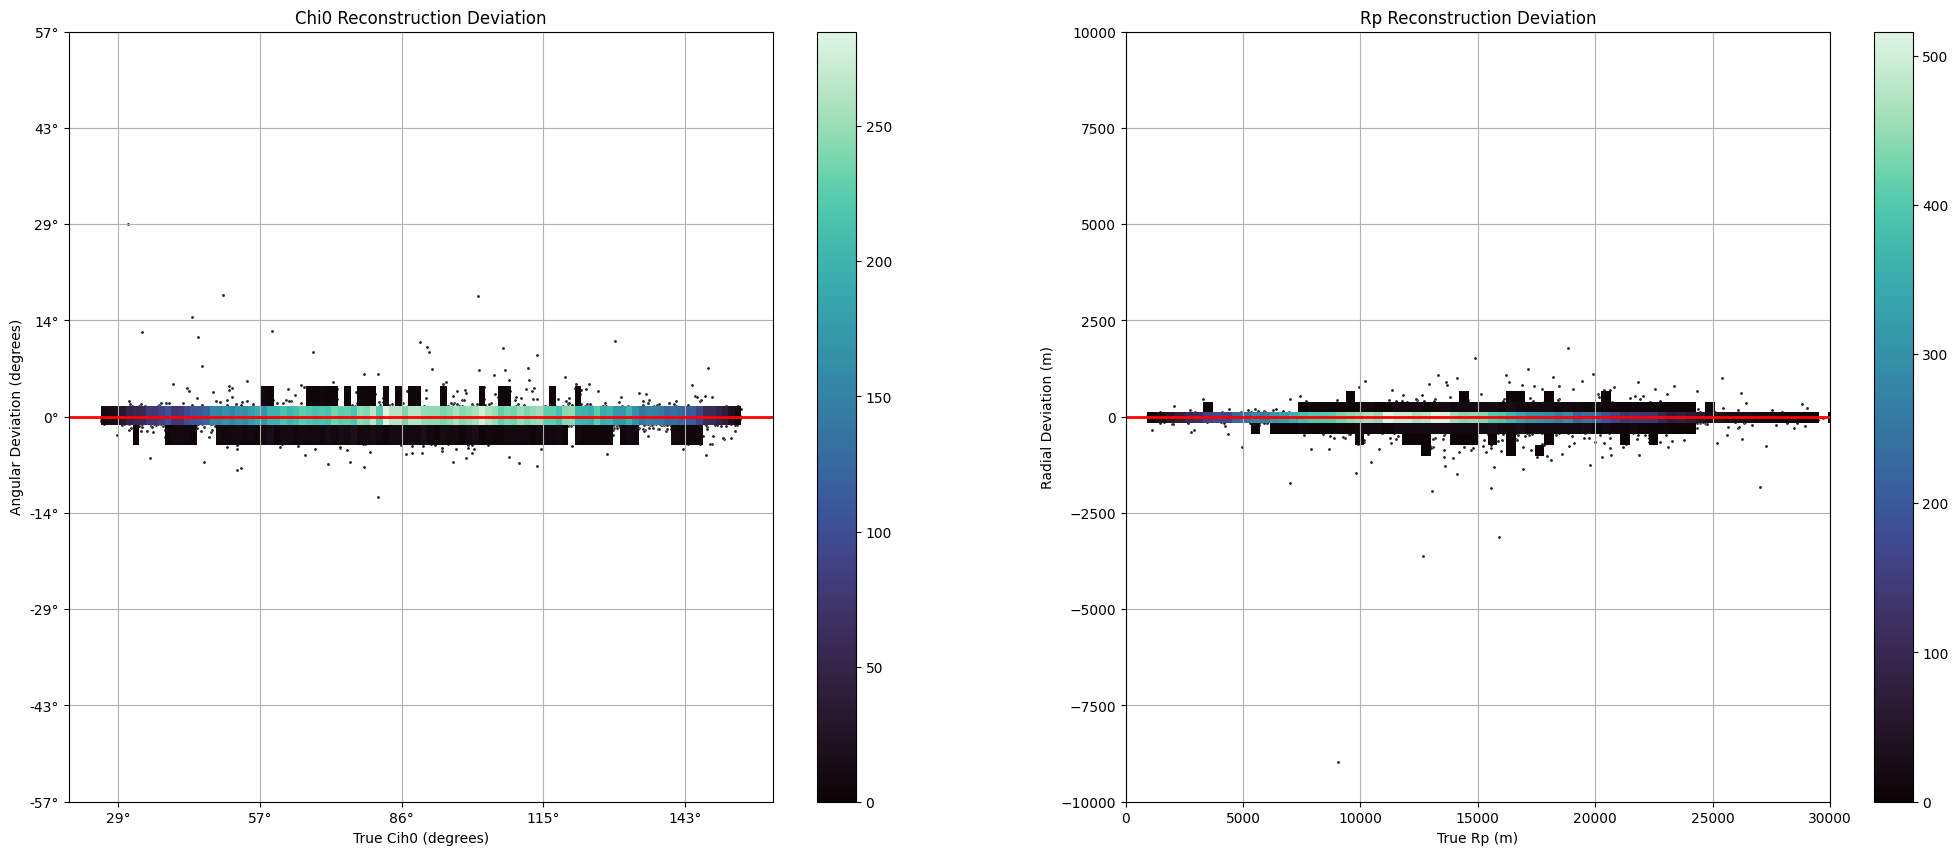

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = Truth[:, 0]
Y = Rec[:, 0] - Truth[:, 0]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.01,cmap = 'mako',cbar = True)
ax[0].set_xlabel('True Cih0 (degrees)') 
ax[0].set_ylabel('Angular Deviation (degrees)')
ax[0].set_title('Chi0 Reconstruction Deviation')
ax[0].axhline(0, color='red', lw=2)
ax[0].set_ylim(-1,1)
ax[0].grid()

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])



X = Truth[:, 1]
Y = Rec[:, 1] - Truth[:, 1]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.01,cmap = 'mako',cbar = True)
ax[1].set_xlabel('True Rp (m)')
ax[1].set_ylabel('Radial Deviation (m)')
ax[1].set_title('Rp Reconstruction Deviation')
ax[1].axhline(0, color='red', lw=2)

ax[1].set_ylim(-10000,10000)
ax[1].set_xlim(0,30000)
ax[1].grid()

plt.show()

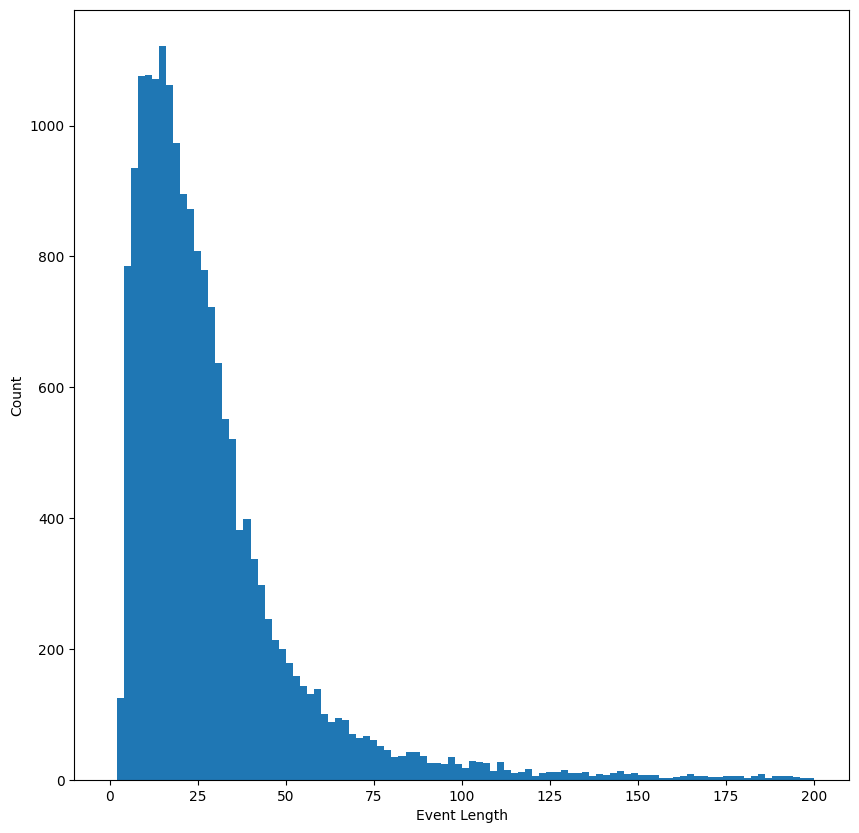

In [62]:
# E vent Length Histogram
plt.figure(figsize=[10,10])
plt.hist(EventLength,bins=100,range=(0,200))
plt.xlabel('Event Length')
plt.ylabel('Count')
plt.show()

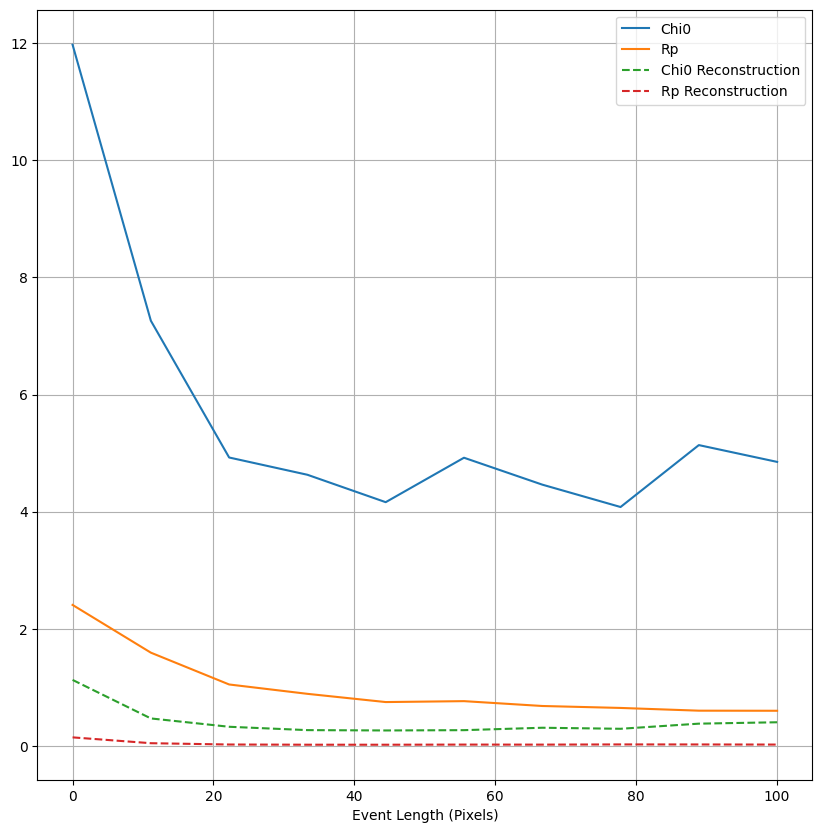

In [61]:
# Prediction Accuracy vs Event Length
Chi0_PCs = []
Rp_PCs   = []

Chi0_PC_Rec = []
Rp_PC_Rec   = []

for i in range(10):
    MinEventSize = i*10
    MaxEventSize = (i+1)*10
    Mask = (EventLength > MinEventSize) & (EventLength < MaxEventSize)
    Chi0_PCs.append(Percentile68(Truth[Mask,0],Pred[Mask,0]))
    Rp_PCs.append(Percentile68(Truth[Mask,1],Pred[Mask,1]))
    Chi0_PC_Rec.append(Percentile68(Truth[Mask,0],Rec[Mask,0]))
    Rp_PC_Rec.append(Percentile68(Truth[Mask,1],Rec[Mask,1]))
                     

Chi0_PCs = np.array(Chi0_PCs)
Rp_PCs = np.array(Rp_PCs)/1000

Chi0_PCs_Rec = np.array(Chi0_PC_Rec)
Rp_PCs_Rec = np.array(Rp_PC_Rec)/1000



plt.figure(figsize=[10,10])
plt.plot(np.linspace(0,100,10),Chi0_PCs*180/np.pi,label='Chi0')
plt.plot(np.linspace(0,100,10),Rp_PCs,label='Rp')
plt.plot(np.linspace(0,100,10),Chi0_PCs_Rec*180/np.pi,label='Chi0 Reconstruction',linestyle='dashed') 
plt.plot(np.linspace(0,100,10),Rp_PCs_Rec,label='Rp Reconstruction',linestyle='dashed')  


plt.xlabel('Event Length (Pixels)')
plt.legend()
plt.grid()
plt.show()


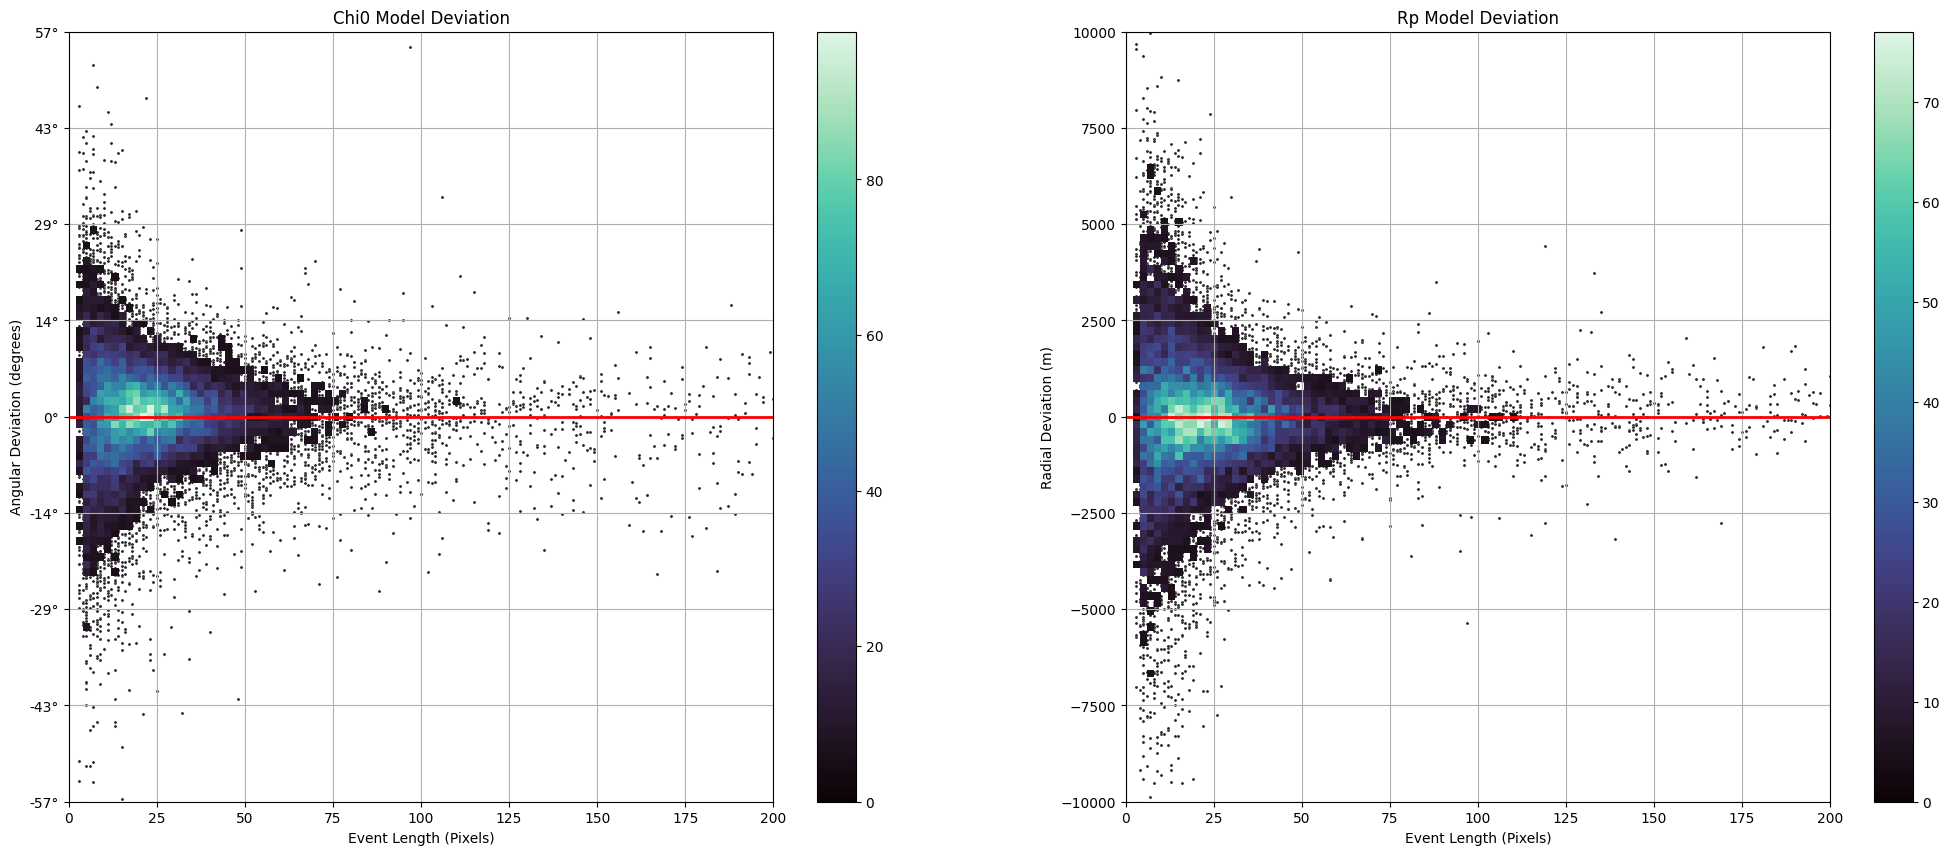

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = EventLength
Y = Pred[:, 0] - Truth[:, 0]
BinsX = np.linspace(0,200,100)
BinsY = np.linspace(-1,1,100)

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=(BinsX,BinsY), pthresh=.1,cmap = 'mako',cbar = True)
ax[0].set_xlabel('Event Length (Pixels)') 
ax[0].set_ylabel('Angular Deviation (degrees)')
ax[0].set_title('Chi0 Model Deviation')
ax[0].axhline(0, color='red', lw=2)
ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,200)
ax[0].grid()

# Set y ticks for the first subplot
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])




X = EventLength
Y = Pred[:, 1] - Truth[:, 1]
BinsX = np.linspace(0,200,100)
BinsY = np.linspace(-10000,10000,100)



sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=(BinsX,BinsY), pthresh=.1,cmap = 'mako',cbar = True)
ax[1].set_xlabel('Event Length (Pixels)')
ax[1].set_ylabel('Radial Deviation (m)')
ax[1].set_title('Rp Model Deviation')
ax[1].axhline(0, color='red', lw=2)
ax[1].set_ylim(-10000,10000)
ax[1].set_xlim(0,200)
ax[1].grid()

plt.show()

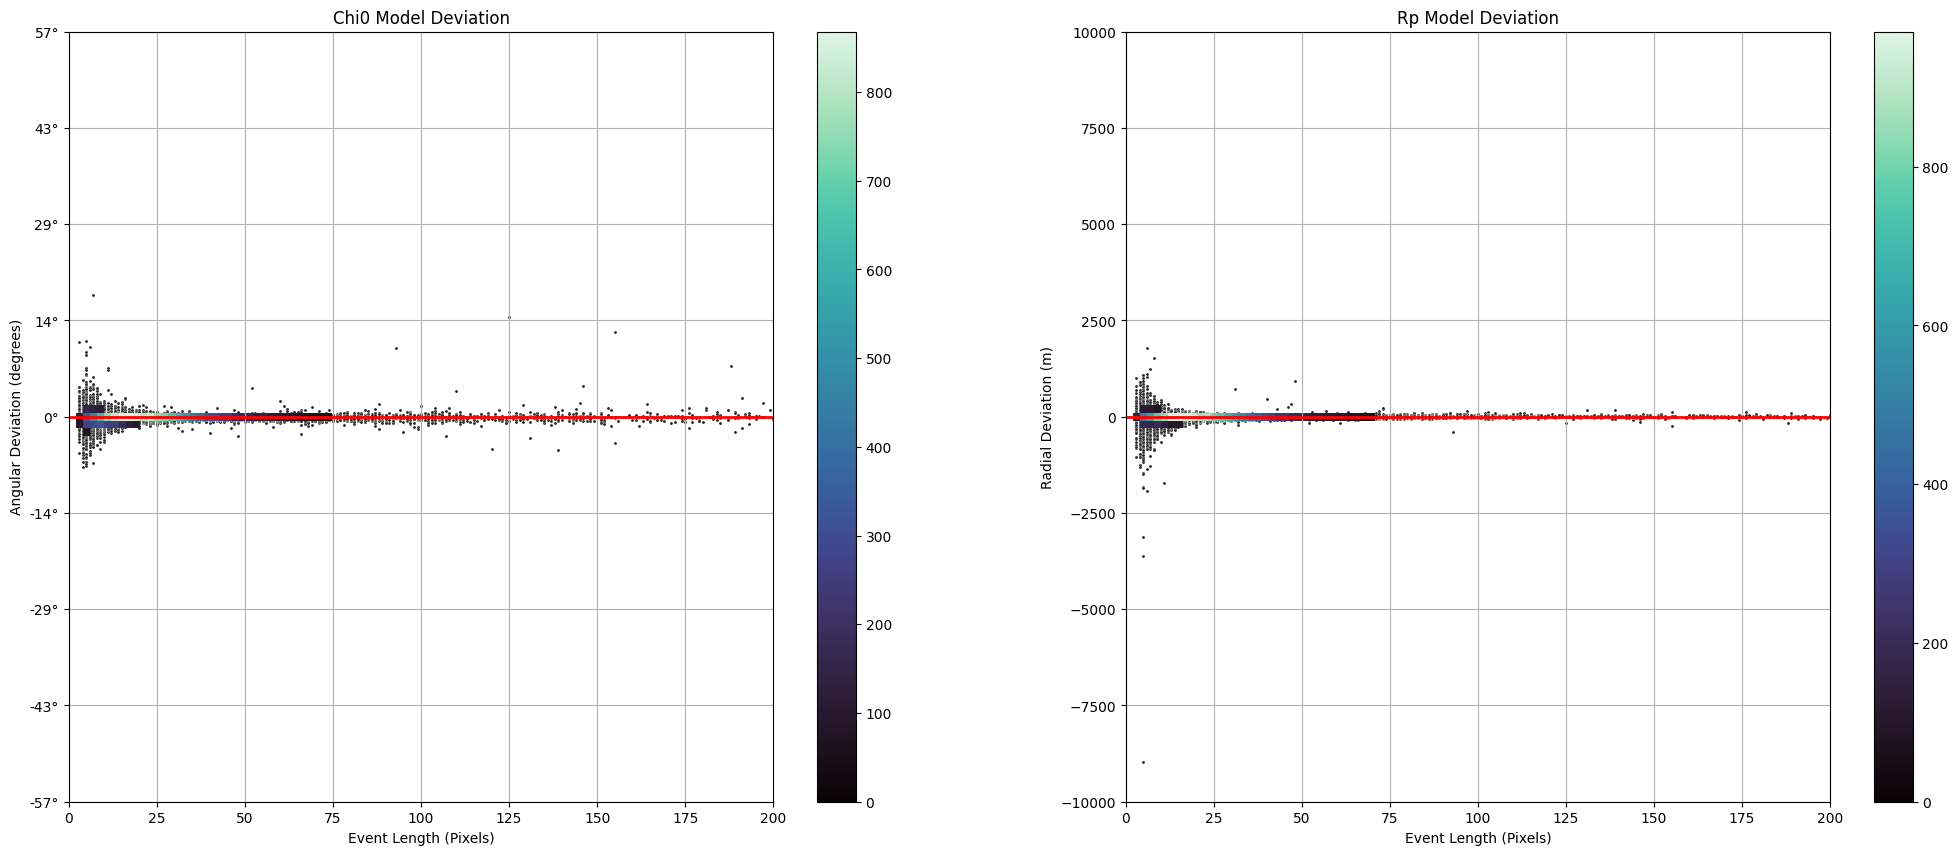

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = EventLength
Y = Rec[:, 0] - Truth[:, 0]
BinsX = np.linspace(0,200,100)
BinsY = np.linspace(-1,1,100)

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=(BinsX,BinsY), pthresh=.1,cmap = 'mako',cbar = True)
ax[0].set_xlabel('Event Length (Pixels)') 
ax[0].set_ylabel('Angular Deviation (degrees)')
ax[0].set_title('Chi0 Model Deviation')
ax[0].axhline(0, color='red', lw=2)
ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,200)
ax[0].grid()

# Set y ticks for the first subplot
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])




X = EventLength
Y = Rec[:, 1] - Truth[:, 1]
BinsX = np.linspace(0,200,100)
BinsY = np.linspace(-10000,10000,100)



sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=(BinsX,BinsY), pthresh=.1,cmap = 'mako',cbar = True)
ax[1].set_xlabel('Event Length (Pixels)')
ax[1].set_ylabel('Radial Deviation (m)')
ax[1].set_title('Rp Model Deviation')
ax[1].axhline(0, color='red', lw=2)
ax[1].set_ylim(-10000,10000)
ax[1].set_xlim(0,200)
ax[1].grid()

plt.show()